In [ ]:
import numpy as np
import h5py
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Input, Embedding
from keras.layers import Dense, Merge, Dropout
from keras.layers import LSTM, Bidirectional
from keras import metrics

In [63]:
#with tf.device('/device:GPU:0'):
alphabet = "NACGT"
vocab_size = len(alphabet)
time_steps = 100
embedding_size = 300 # for embedding layer, maybe remove
dense_size = 300
category = 10 # size of Y_vector

model = Sequential()
#model.add(Embedding(vocab_size, embedding_size, batch_input_shape=(batch_size, time_steps)))
model.add(Embedding(vocab_size, embedding_size, input_length=time_steps))


model.add(Bidirectional(LSTM(units=300, return_sequences=True)))
model.add(Dropout(0.50))
model.add(Bidirectional(LSTM(units=300)))
model.add(Dropout(0.50))

model.add(Dense(dense_size, activation='relu'))
model.add(Dense(dense_size, activation='relu'))
model.add(Dense(category, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 300)          1500      
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 100, 600)          1442400   
_________________________________________________________________
dropout_13 (Dropout)         (None, 100, 600)          0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 600)               2162400   
_________________________________________________________________
dropout_14 (Dropout)         (None, 600)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 300)               180300    
_________________________________________________________________
dense_24 (Dense)             (None, 300)               90300     
__________

In [32]:
h5f = h5py.File('X_train_superfam_all_bacteria_and_archaea.h5','r')
X_train = h5f['X'][:]
h5f.close()
h5f = h5py.File('Y_train_superfam_all_bacteria_and_archaea.h5','r')
Y_train = h5f['Y'][:]
h5f.close()
print(X_train.shape)
print(Y_train.shape)

(100000, 100)
(100000, 10)


In [64]:
#random_index = np.random.permutation(Y_train.shape[0])
#Y_train_fake = Y_train[random_index, :]

batch_size = 128
history = model.fit(X_train, Y_train,
                    validation_split=0.2, 
                    batch_size=batch_size, shuffle=True, epochs=50)

Train on 80000 samples, validate on 20000 samples
Epoch 1/50
80000/80000 [==============================] - 858s - loss: 1.0888 - mean_squared_error: 1.0888 - val_loss: 1.1190 - val_mean_squared_error: 1.1190
Epoch 2/50
80000/80000 [==============================] - 863s - loss: 1.0821 - mean_squared_error: 1.0821 - val_loss: 1.1203 - val_mean_squared_error: 1.1203
Epoch 3/50
80000/80000 [==============================] - 875s - loss: 1.0790 - mean_squared_error: 1.0790 - val_loss: 1.1133 - val_mean_squared_error: 1.1133
Epoch 4/50
80000/80000 [==============================] - 862s - loss: 1.0722 - mean_squared_error: 1.0722 - val_loss: 1.1022 - val_mean_squared_error: 1.1022
Epoch 5/50
80000/80000 [==============================] - 884s - loss: 1.0666 - mean_squared_error: 1.0666 - val_loss: 1.1012 - val_mean_squared_error: 1.1012
Epoch 6/50
80000/80000 [==============================] - 853s - loss: 1.0598 - mean_squared_error: 1.0598 - val_loss: 1.0905 - val_mean_squared_error: 1.0

In [65]:
from keras.models import load_model
import copy
import pickle

#history_epoch_1_50_100K = copy.deepcopy(history.history)
#history_epoch_50_100_100K = copy.deepcopy(history.history)

#history.history['mean_squared_error'] = history_epoch_1_50_100K['mean_squared_error'] + history.history['mean_squared_error']
#history.history['val_mean_squared_error'] = history_epoch_1_50_100K['val_mean_squared_error'] + history.history['val_mean_squared_error']

with open('Nov_25_100K_model_history.txt', 'wb') as handle:
    pickle.dump(history.history, handle)

#print(history_epoch_1_50_100K)

model.save('Nov_25_100K_model.h5')

#del model 
#model = load_model(''Nov_14_1K_model.h5'')

In [14]:
model.predict(X_train[:3])

array([[ 0.25853473, -1.30948186, -0.10837211,  0.28570136, -0.57212687,
         0.9984743 , -0.34912622,  0.18345138, -0.24738713, -0.06839444],
       [-2.2571497 , -0.60515702,  0.73129684,  2.03917861,  0.04138111,
         0.94244081, -0.04987083,  0.64583069,  1.43022692,  0.5391891 ],
       [ 0.39796314, -0.28623649, -0.14622551, -0.40161222,  0.22569293,
        -0.18637928,  0.58562428, -0.09304373,  0.9354651 ,  0.32007751]], dtype=float32)

In [12]:
Y_train[:3]

array([[ 0.27738296, -1.29981422, -0.10408728,  0.20743367, -0.5760618 ,
         1.0140479 , -0.33179031,  0.15838494, -0.25340111, -0.0586683 ],
       [-2.18598496, -0.52927834,  0.74488742,  1.9812408 ,  0.04650106,
         0.94405667, -0.03417571,  0.677128  ,  1.40715764,  0.54621637],
       [ 0.39932728, -0.37849463, -0.09790586, -0.3786228 ,  0.23854922,
        -0.20412457,  0.60858615, -0.11622692,  1.01866357,  0.28075107]])

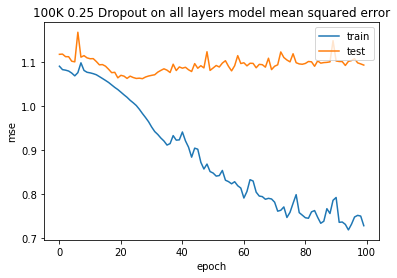

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.plot(history_epoch_1_50_100K['mean_squared_error'] + history_epoch_50_100_100K['mean_squared_error'])
#plt.plot(history_epoch_1_50_100K['val_mean_squared_error'] + history_epoch_50_100_100K['val_mean_squared_error'])
with open('Nov_20_100K_model_history.txt', 'rb') as handle:
    saved_history = pickle.loads(handle.read())
plt.plot(saved_history['mean_squared_error'])
plt.plot(saved_history['val_mean_squared_error'])
plt.title('100K 0.25 Dropout on all layers model mean squared error')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [25]:
# EVALUATION STARTS HERE
h5f = h5py.File('X_test_superfam_all_bacteria_and_archaea.h5','r')
X_test = h5f['X'][:]
h5f.close()

In [31]:
predictions = model.predict(X_test)
print(predictions)

[[  1.79523319e-01  -1.02754068e+00   1.44240052e-01   1.03742830e-01
   -3.49766344e-01   4.35492516e-01  -2.29673520e-01  -1.26444474e-01
   -7.14808404e-02   4.34234291e-02]
 [ -3.12592089e-01   2.26203233e-01  -1.46266043e-01   3.06233108e-01
    1.49662286e-01  -5.66627756e-02   7.85024345e-01   2.45194092e-01
   -8.17311525e-01   4.84225392e-01]
 [ -2.07193851e-01  -6.10414743e-01   1.53332755e-01   2.69457817e-01
   -1.22271672e-01   7.20564544e-01   3.55935872e-01   4.32757258e-01
   -5.54055631e-01   2.82940924e-01]
 [  1.40226319e-01  -3.31414878e-01  -2.21586645e-01  -4.53011319e-02
    5.27930975e-01   8.58404934e-02   1.78249329e-02  -4.16439809e-02
    4.66707766e-01   5.60805202e-02]
 [ -7.35617518e-01   6.50053859e-01   1.56722617e+00  -5.08813024e-01
   -7.48821795e-02  -3.04057688e-01   4.89548028e-01   2.42122427e-01
   -5.95070124e-01   4.90056276e-02]
 [  6.16651177e-02  -3.40554744e-01   1.07232474e-01  -7.60531873e-02
    1.92932323e-01  -7.89727494e-02   7.20040

In [30]:
h5f_Y = h5py.File('test_evaluation_superfam_all_bacteria_and_archaea.h5', 'w')
h5f_Y.create_dataset('Y', data=predictions)
h5f_Y.close()

(100, 10)
